In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm, trange
import random
import time

In [3]:
from experiencereplay import ExperienceReplay, PrioritizedExperienceReplay, ModelBasedPrioritizedExperienceReplay
from experiment import Experiment
from deepmlac import DeepMLAC
import nn
from exploration import EpsilonGreedyStrategy, OUStrategy

In [4]:
settings = dict(
    environment = 'Pendulum-v0',
    timesteps = 2500,
    max_replay_buffer_size = 100000,
    batch_size = 256,
    learning_start = 256,
    forward_steps = 3,
    discount_factor = 0.9,
    trace_decay = 0.5,
    
    actor_learning_rate=0.0001,
    model_learning_rate=0.001,
    reward_learning_rate=0.001,
    value_learning_rate=0.001,
    
    actor_l2=None,
    model_l2=None,
    reward_l2=None,
    value_l2=None,
    
    actor_target_approach_rate=0.99,
    value_target_approach_rate=0.99,
    
    train_updates_per_step = 10,
    priority_updates_per_step = 100,
    
    actor_net_layers = [256, 128],
    actor_net_activation_fn = tf.nn.elu,
    actor_bounded_output = True,
    value_net_layers =  [256, 128],
    value_net_activation_fn = tf.nn.elu,
    model_net_encoding = 128,
    model_net_layers = [128],
    model_net_activation_fn = tf.nn.elu,
    reward_net_encoding = 128,
    reward_net_layers =  [128],
    reward_net_activation_fn = tf.nn.elu,
    
    environment_seed = 0,
    noise_seed= 0,
    
    gpu_memory_fraction = 0.1,
    
    render_environment = True,
    render_frequency = 60,
    render_start=1500,
)

settings["experiment_path"] = "experiments/experiment_deepmlac_{}_{}".format(settings["environment"], int(time.time()))
settings["actor_tf_optimizer"] = tf.train.AdamOptimizer(settings["actor_learning_rate"])
settings["model_tf_optimizer"] = tf.train.AdamOptimizer(settings["model_learning_rate"])
settings["reward_tf_optimizer"] = tf.train.AdamOptimizer(settings["reward_learning_rate"])
settings["value_tf_optimizer"] = tf.train.AdamOptimizer(settings["value_learning_rate"])

print(settings["experiment_path"])

experiments/experiment_deepmlac_Pendulum-v0_1493491239


In [5]:
def preprocess_state(observation):
    state = np.array(observation)
    if settings["environment"] == "MountainCarContinuous-v0":
        state[1] = state[1] * 10
        return state
    else:
        return state
    
def preprocess_reward(reward):
    if settings["environment"] == "MountainCarContinuous-v0":
        return reward * 0.01
    else:
        return reward

In [6]:
env = gym.make(settings["environment"])
env.seed(settings["environment_seed"])

observation = preprocess_state(env.reset())
state = observation

[2017-04-29 20:40:39,881] Making new env: Pendulum-v0


In [7]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(state_dim)
print(action_dim)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)

3
1
[ 1.  1.  8.]
[-1. -1. -8.]
[ 2.]
[-2.]


In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=settings["gpu_memory_fraction"])
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
summary_writer = tf.summary.FileWriter(settings["experiment_path"] + "/logdir")

In [9]:
actor_network = nn.fully_connected("Actor", session, [state_dim], settings["actor_net_layers"],
                                   action_dim, settings["actor_net_activation_fn"],
                                   env.action_space if settings["actor_bounded_output"] else None, False)
model_network = nn.fully_connected_with_input_encoding(
    "Model", session, [state_dim, action_dim], settings["model_net_encoding"], settings["model_net_layers"], state_dim,
     settings["model_net_activation_fn"], None, False)
reward_network = nn.fully_connected_with_input_encoding(
    "Reward", session, [state_dim, action_dim], settings["reward_net_encoding"], settings["reward_net_layers"], 1,
     settings["reward_net_activation_fn"], None, False)
value_network = nn.fully_connected("Value", session, [state_dim], settings["value_net_layers"], 1,
                               settings["value_net_activation_fn"], None, False)
print(str(actor_network))

[] --> Actor_input_0
['Actor_input_0'] --> hidden_0_256
['hidden_0_256'] --> hidden_1_128
['hidden_1_128'] --> output
['output'] --> bounding



In [10]:
agent = DeepMLAC(actor_network, model_network, reward_network, value_network,
                 forward_steps=settings["forward_steps"],
                 discount_factor=settings["discount_factor"],
                 trace_decay=settings["trace_decay"],
                 actor_tf_optimizer=settings["actor_tf_optimizer"],
                 model_tf_optimizer=settings["model_tf_optimizer"],
                 reward_tf_optimizer=settings["reward_tf_optimizer"],
                 value_tf_optimizer=settings["value_tf_optimizer"],
                 actor_l2=settings["actor_l2"],
                 model_l2=settings["model_l2"],
                 reward_l2=settings["reward_l2"],
                 value_l2=settings["value_l2"],
                 actor_target_approach_rate=settings["actor_target_approach_rate"],
                 value_target_approach_rate=settings["value_target_approach_rate"],
                 summary_writer=summary_writer
                )

[] --> Actor_target_input_0
['Actor_target_input_0'] --> hidden_0_256
['hidden_0_256'] --> hidden_1_128
['hidden_1_128'] --> output
['output'] --> bounding

[] --> Value_target_input_0
['Value_target_input_0'] --> hidden_0_256
['hidden_0_256'] --> hidden_1_128
['hidden_1_128'] --> output



In [11]:
saver = tf.train.Saver()
summary_writer.add_graph(session.graph)

In [12]:
experience_replay = ModelBasedPrioritizedExperienceReplay(agent, env, settings["max_replay_buffer_size"])

In [13]:
exploration_strategy = EpsilonGreedyStrategy(agent, env, settings["noise_seed"])

In [14]:
exp = Experiment(settings["experiment_path"], session, env, settings, settings["render_environment"], settings["render_frequency"], settings["render_start"])

progress_bar = tqdm(total=settings["timesteps"])

e_t = -1
for t in xrange(settings["timesteps"]):
    e_t += 1
    exploration = ((settings["timesteps"] - t) / float(settings["timesteps"])) ** 2
    if t < settings["learning_start"]:
        exploration = 1
    
    action = exploration_strategy.action(state, exploration)
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(preprocess_state(observation), (state_dim,))
    
    experience_replay.add_experience(state, action, preprocess_reward(reward), next_state, done)
    td_error = math.fabs(experience_replay.get_last_td_error())
    model_error = experience_replay.get_last_model_error()
    reward_error = experience_replay.get_last_reward_error()

    exp.record(t, state, action, reward, next_state, done, td_error, model_error, reward_error)
    
    state = next_state
    
    if done:
        observation = env.reset()
        state = preprocess_state(observation)
        e_t = -1
        
    if t >= settings["learning_start"]:
        experience_replay.train_agent(settings["batch_size"], settings["train_updates_per_step"])
        experience_replay.update_oldest_priorities(settings["priority_updates_per_step"])
            
    progress_bar.set_description('[{}] reward: {:.2f}, reward 100-step MA: {:.2f}, Exploration: {:.2f}, action: {}, td-error: {:.4f}, model error: {:.4f}, reward error: {:.4f}' \
        .format(t, reward, exp.reward_100ma.get_average(), exploration, str(action), td_error, model_error, reward_error))
    progress_bar.update()
    
        
progress_bar.close()

[2499] reward: -0.04, reward 100-step MA: -0.06, Exploration: 0.00, action: [-1.02118051], td-error: 0.0000, model error: 0.0000, reward error: 0.0001: 100%|██████████| 2500/2500 [06:46<00:00,  5.45it/s]   | 1/2500 [00:00<17:08,  2.43it/s]


In [15]:
exp.save()
print("Experiment results saved in " + exp.path)

Experiment results saved in experiments/experiment_deepmlac_Pendulum-v0_1493491239


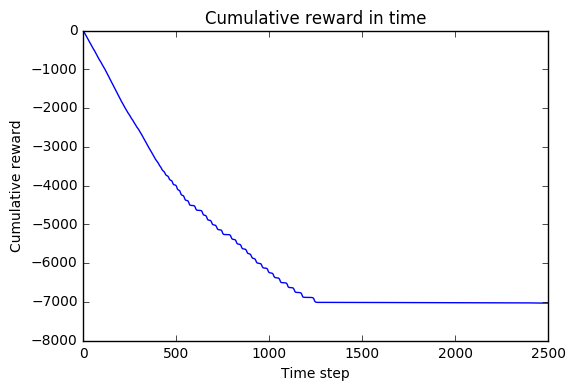

In [16]:
exp.plot_cumulative_reward()

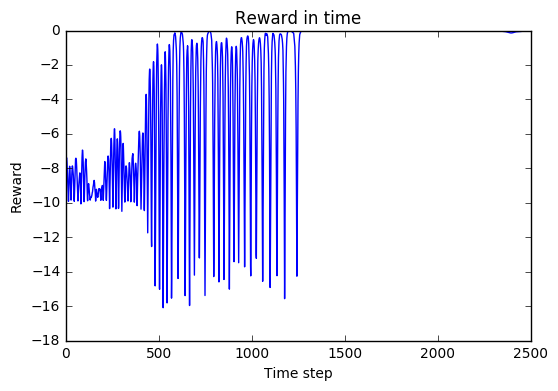

In [17]:
exp.plot_reward()

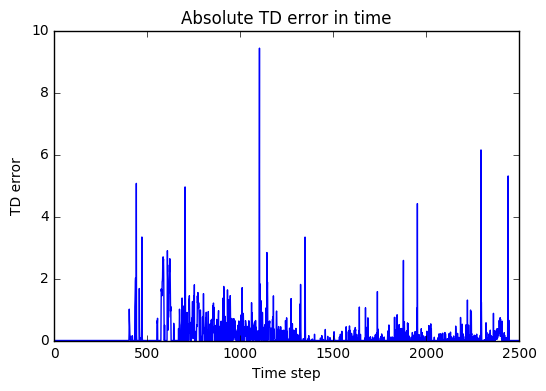

In [18]:
exp.plot_td_error()

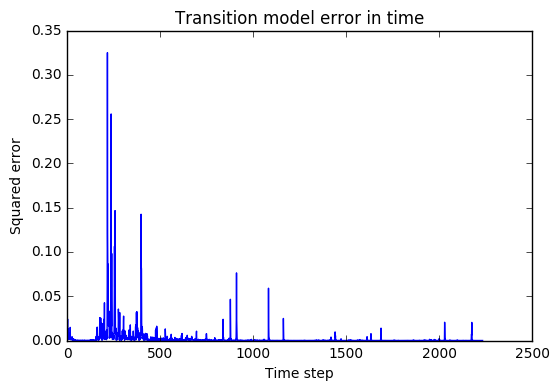

In [19]:
exp.plot_model_error(skip_steps=settings["learning_start"]+10)

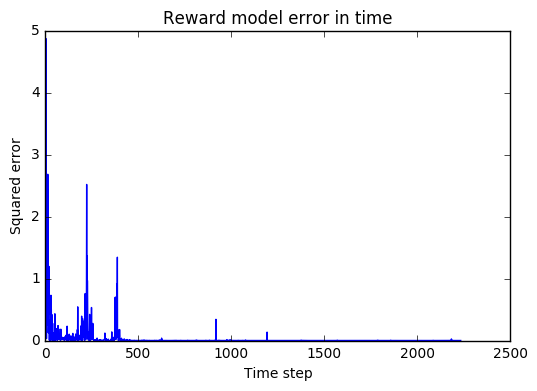

In [20]:
exp.plot_reward_error(skip_steps=settings["learning_start"]+10)

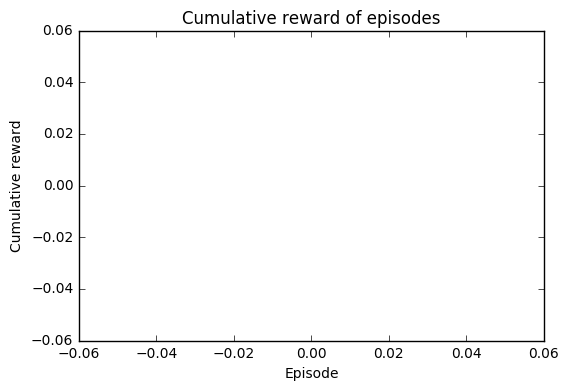

In [21]:
exp.plot_episode_reward()

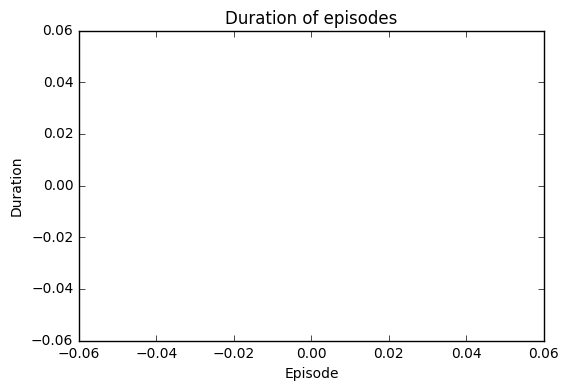

In [22]:
exp.plot_episode_duration()


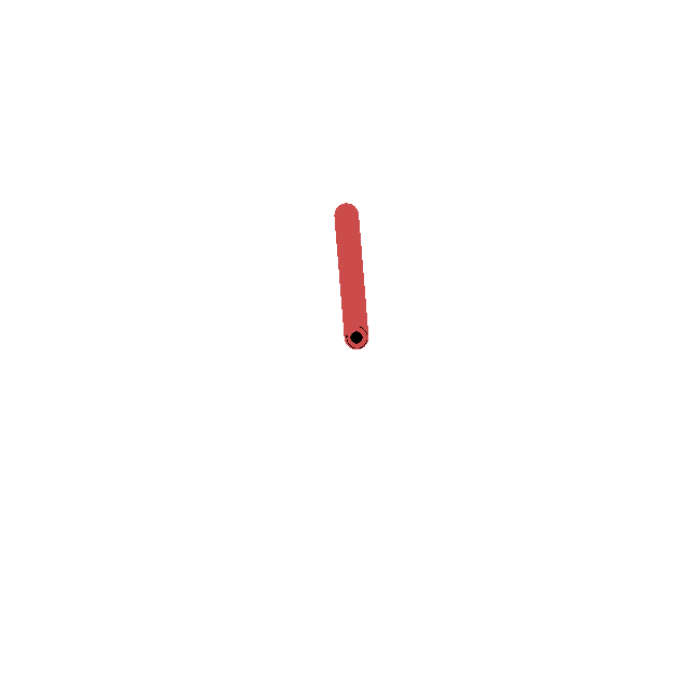
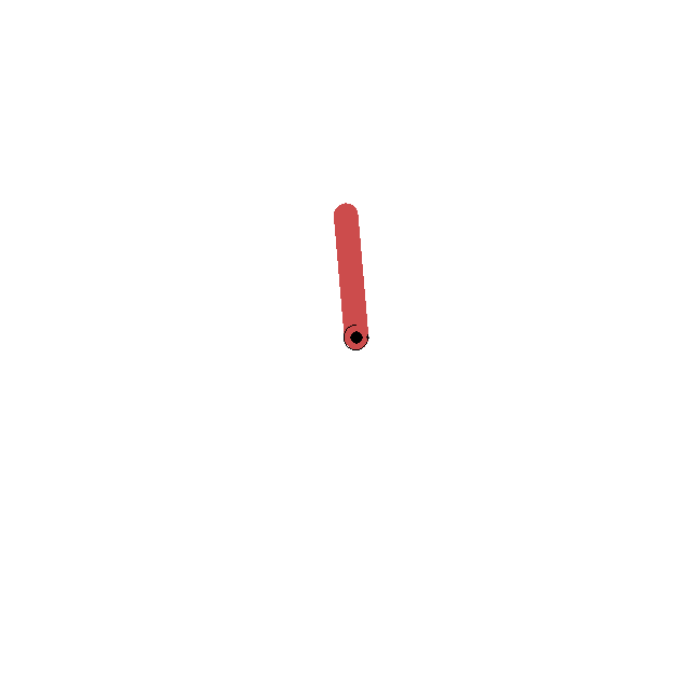
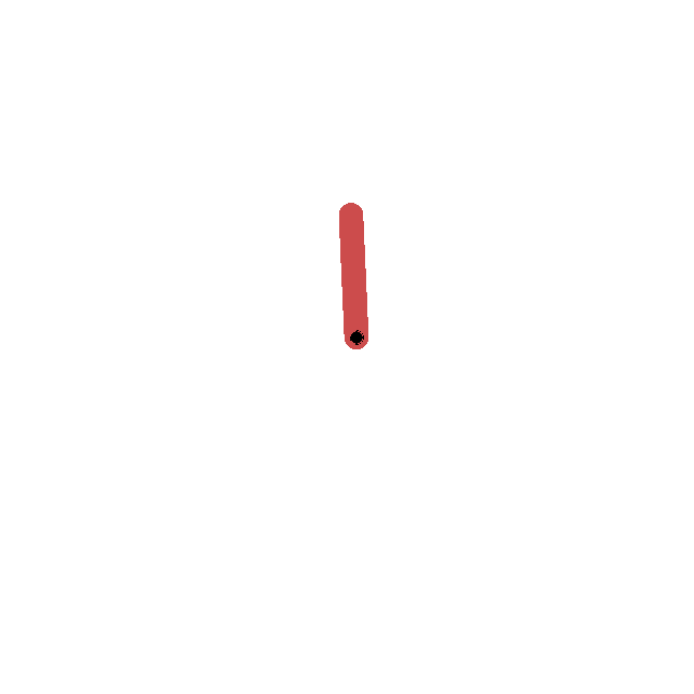
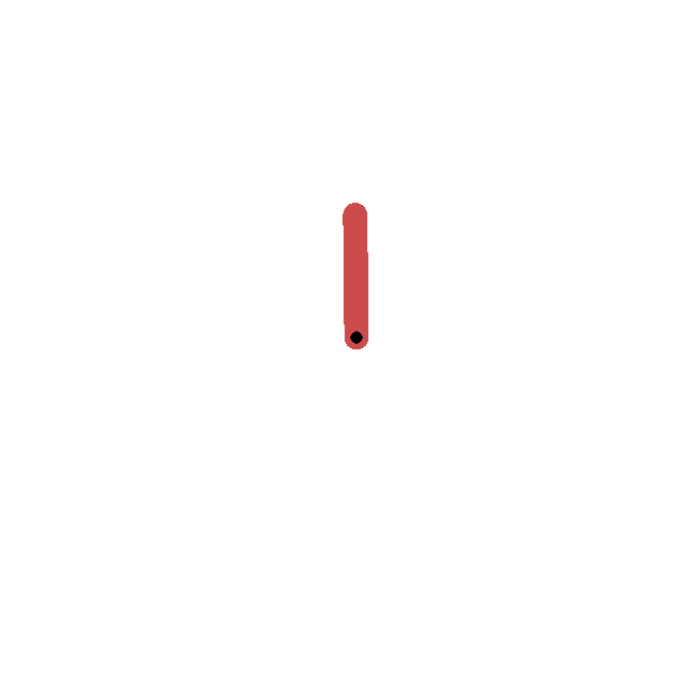
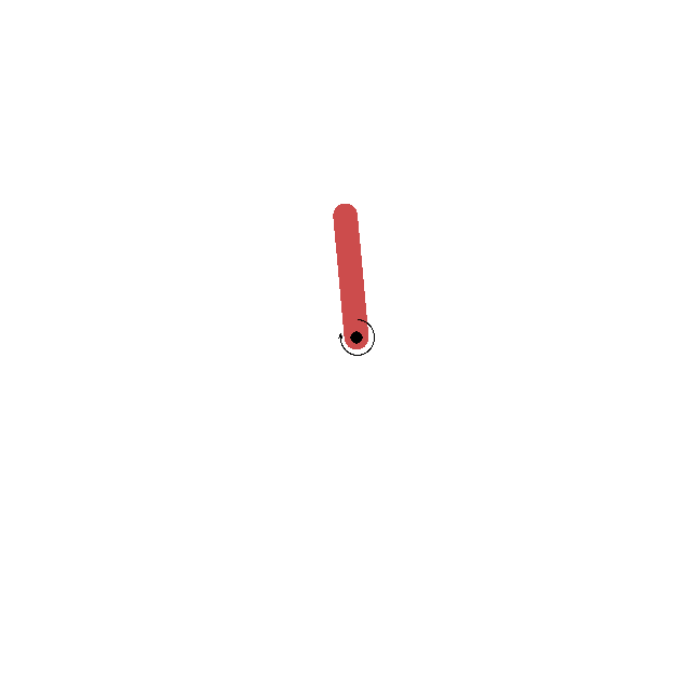
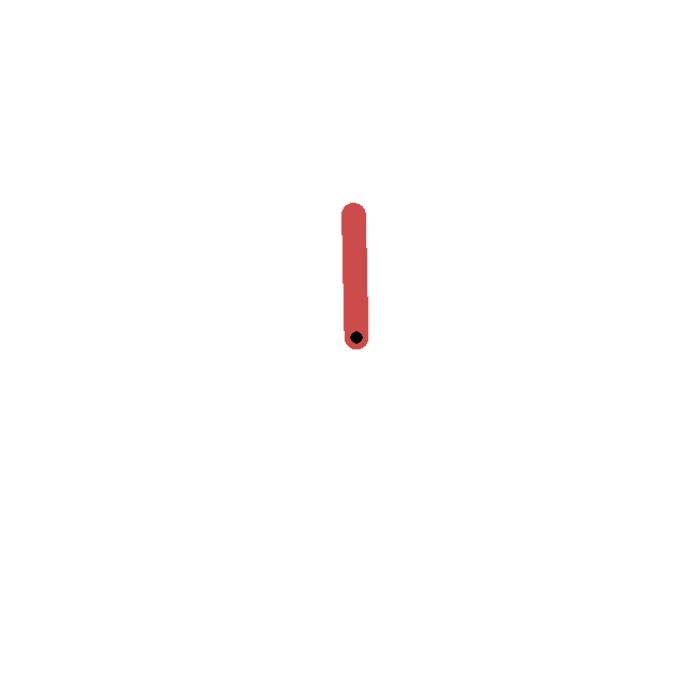
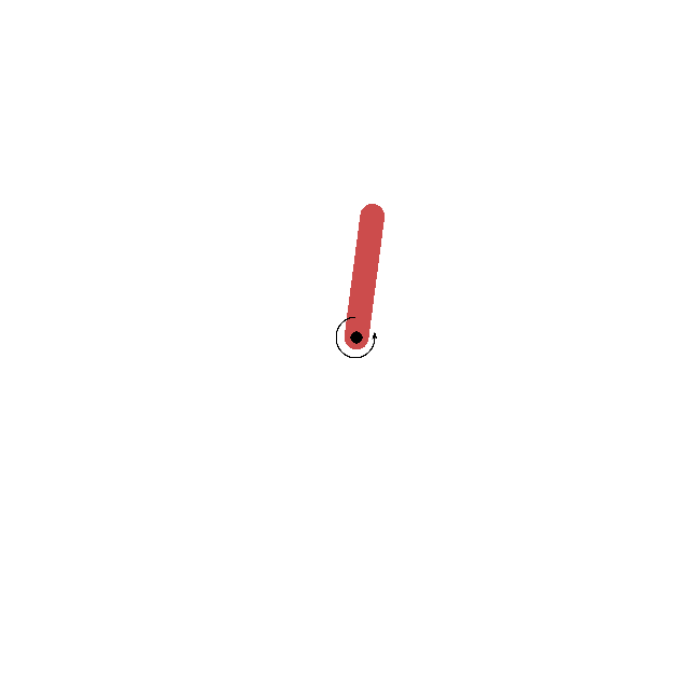
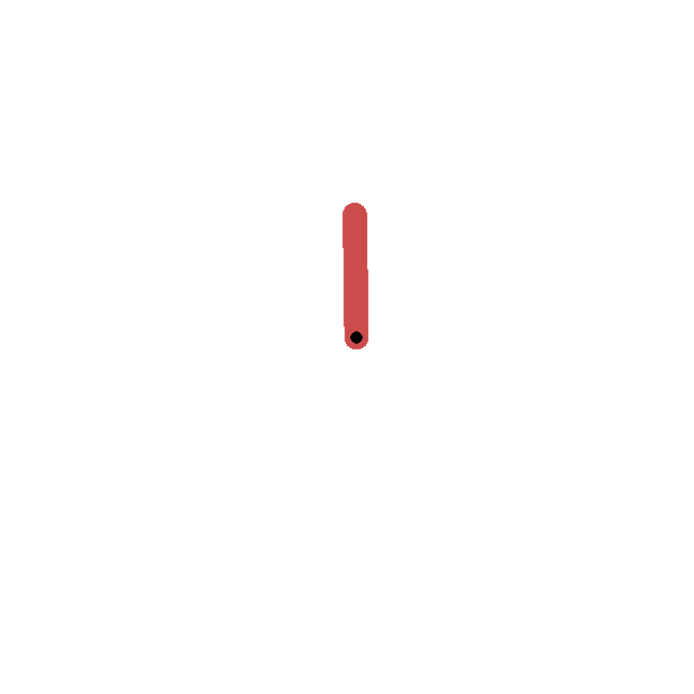
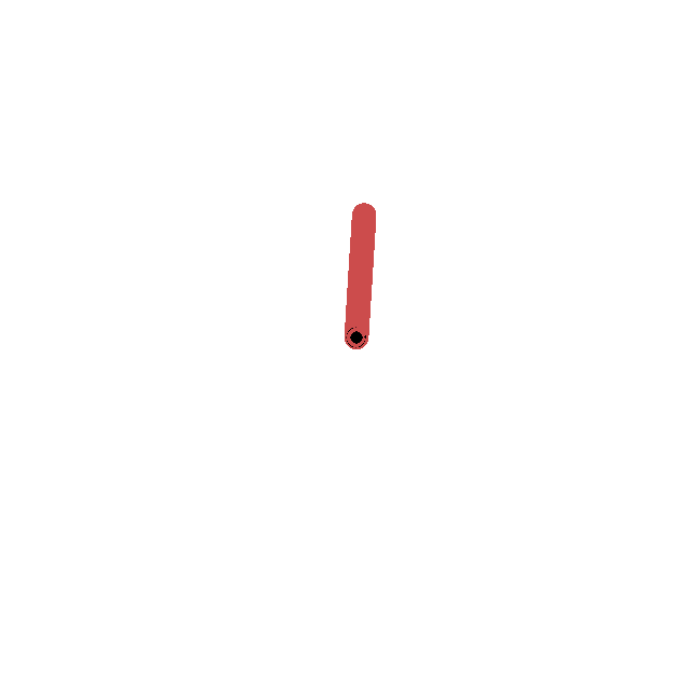
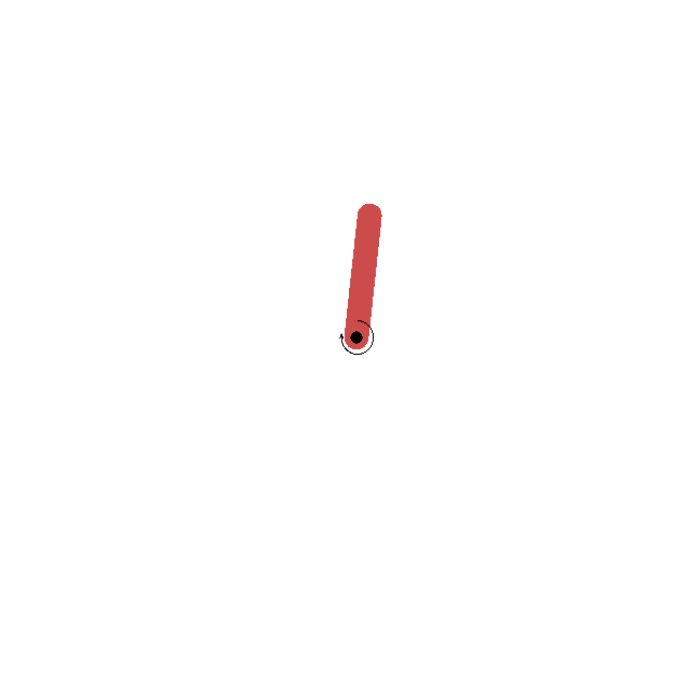
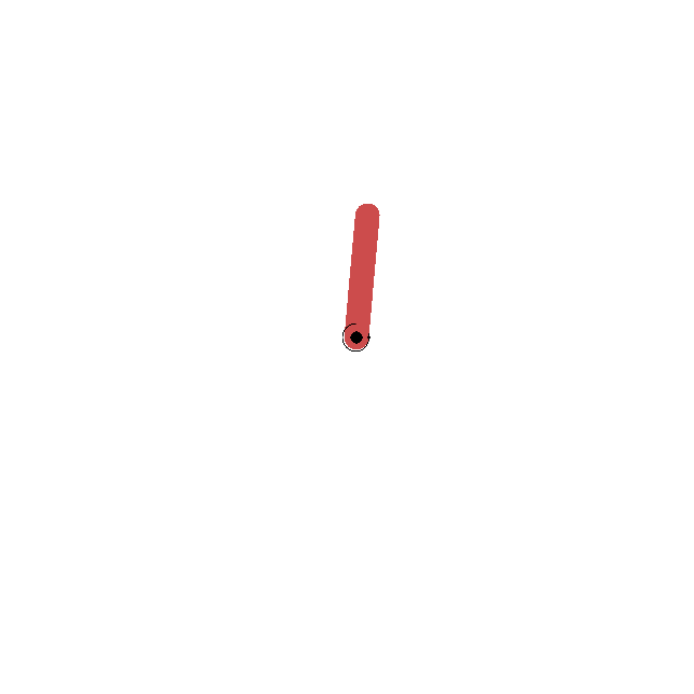
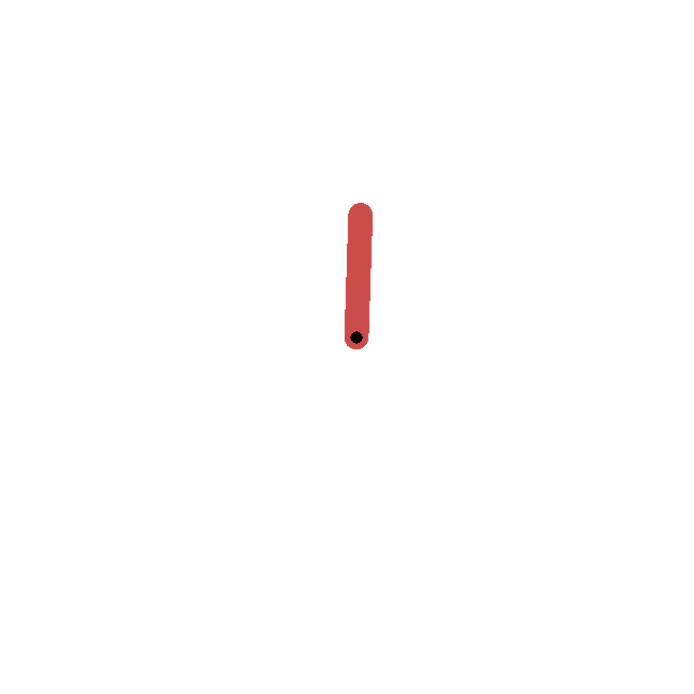
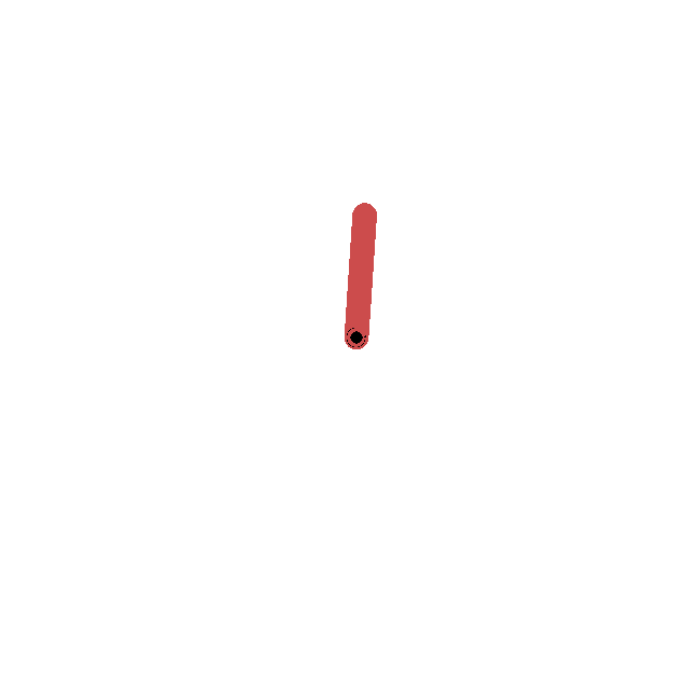
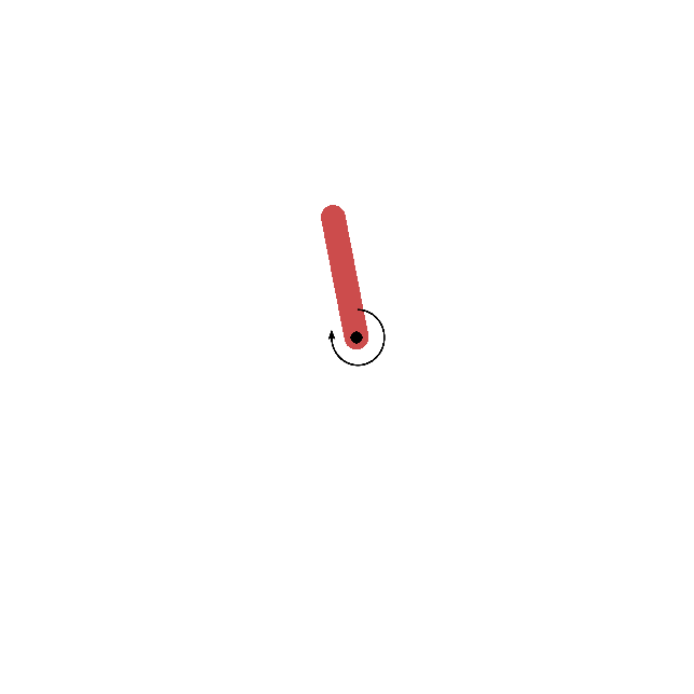
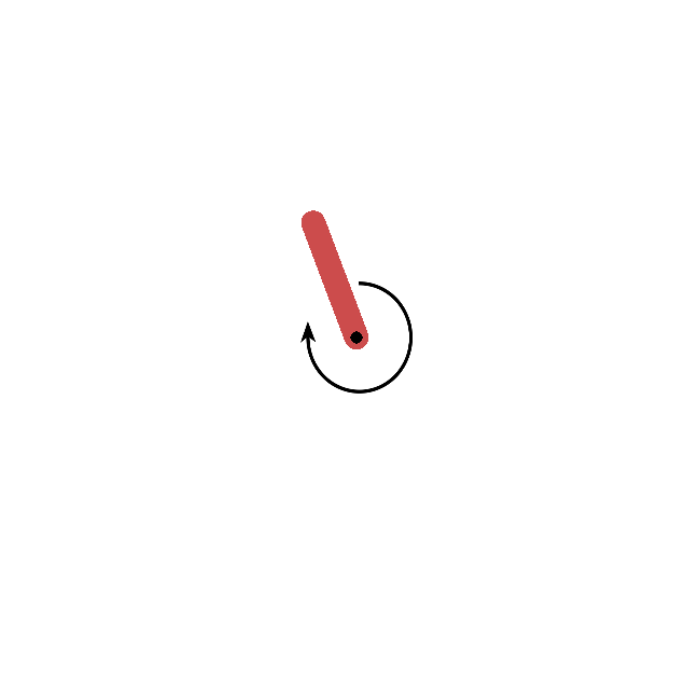
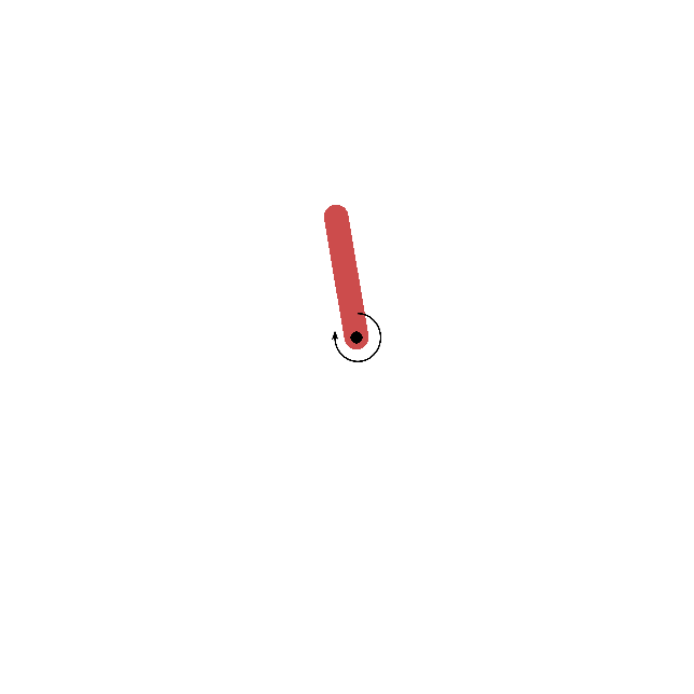

In [23]:
if settings["render_environment"]:
    exp.display_frames_as_gif()

In [24]:
#session.close() 

In [25]:
exp.print_all_tf_variables()

(u'Actor_hidden_0_256_W:0', array([[ -1.37161100e+00,  -8.38826418e-01,  -6.50027692e-02,
          7.23001540e-01,  -4.68669832e-01,  -2.01427713e-01,
         -4.04742539e-01,   4.77099158e-02,  -1.10191166e+00,
         -6.19509459e-01,  -2.92575568e-01,  -9.88355875e-02,
         -1.15623355e+00,   1.30845800e-01,  -5.70862412e-01,
         -6.69442296e-01,  -1.65683973e+00,   8.58674869e-02,
         -1.36610687e-01,  -2.31461629e-01,   1.16582394e+00,
          3.13672811e-01,  -2.43977189e-01,   4.87104326e-01,
         -7.82305598e-02,   5.39557748e-02,   6.16785847e-02,
          5.76382935e-01,   3.36894542e-01,   4.05856401e-01,
          6.44671023e-01,  -4.36244011e-01,   3.46920371e-01,
          1.05767977e+00,  -3.42728123e-02,  -9.78845298e-01,
         -1.08109915e+00,   7.20009983e-01,  -6.14342242e-02,
          2.25570396e-01,  -1.51053891e-01,  -1.24089941e-01,
         -3.85592550e-01,   1.00836158e+00,  -3.93423557e-01,
         -1.34161961e+00,  -8.71635437e-01